In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn
from dgl.data import CoraGraphDataset, CiteseerGraphDataset, PubmedGraphDataset
from dgl import AddSelfLoop
import argparse
import time 
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
    

In [1]:
def evaluate(features, labels, mask, model):
    model.eval()
    with torch.no_grad():
        logits = model( features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
    
def train(features, labels, masks, model):
    # define train/val samples, loss function and optimizer
    train_mask = masks[0]
    val_mask = masks[1]
    loss_fcn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)

    #training loop        
    for epoch in range(100):
        model.train()
        logits = model( features)
        loss = loss_fcn(logits[train_mask], labels[train_mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = evaluate(features, labels, val_mask, model)
        print("Epoch {:05d} | Loss {:.4f} | Accuracy {:.4f} "
              . format(epoch, loss.item(), acc))
        

In [2]:


class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.reset_parameters()
        
    def edge_attention(self, edges):
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e' : F.leaky_relu(a)}
    def reset_parameters(self):
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)
    
    def message_func(self, edges):
        return {'z' : edges.src['z'], 'e' : edges.data['e']}
    
    def reduce_func(self, nodes):
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h' : h}
    
    def forward(self, h):
        z = self.fc(h) # eq. 1
        self.g.ndata['z'] = z 
        self.g.apply_edges(self.edge_attention) # eq. 2
        self.g.update_all(self.message_func, self.reduce_func) # eq. 3 and 4
        return self.g.ndata.pop('h')
    
    
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge
        
    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            return torch.cat(head_outs, dim=1)
        else:
            return torch.mean(torch.stack(head_outs))
            
class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)
        
    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh

def load_core_data():
    data = CoraGraphDataset(transform=transform)
    g = data[0]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    g = g.int().to(device)
    features = g.ndata['feat']
    labels = g.ndata['label']
    mask = g.ndata['train_mask'], g.ndata['val_mask'], g.ndata['test_mask']
    return g, features, labels, mask
device = torch.device('cpu')
transform = AddSelfLoop()
g, features, labels, masks = load_core_data()

# create GAT model    
in_size = features.shape[1]
out_size = 7
model = GAT(g, in_dim=in_size, hidden_dim=8, out_dim=out_size, num_heads=8).to(device)

# model training
print('Training...')
train(features, labels, masks, model)

# test the model
print('Testing...')
acc = evaluate(features, labels, masks[2], model)
print("Test accuracy {:.4f}".format(acc))

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Training...
Epoch 00000 | Loss 1.9440 | Accuracy 0.2660 
Epoch 00001 | Loss 1.9399 | Accuracy 0.3140 
Epoch 00002 | Loss 1.9359 | Accuracy 0.3600 
Epoch 00003 | Loss 1.9319 | Accuracy 0.4160 
Epoch 00004 | Loss 1.9280 | Accuracy 0.4720 
Epoch 00005 | Loss 1.9240 | Accuracy 0.5340 
Epoch 00006 | Loss 1.9200 | Accuracy 0.5760 
Epoch 00007 | Loss 1.9160 | Accuracy 0.5980 
Epoch 00008 | Loss 1.9120 | Accuracy 0.6160 
Epoch 00009 | Loss 1.9080 | Accuracy 0.6300 
Epoch 00010 | Loss 1.9040 | Accuracy 0.6480 
Epoch 00011 | Loss 1.8999 | Accuracy 0.6580 
Epoch 00012 | Loss 1.8959 | Accuracy 0.6700 
Epoch 00013 | Loss 1.8918 | Accuracy 0.6860 
Epoch 00014 | Loss 1.8878 | Accuracy 0.6980 
Epoch 00015 | Loss 1.8837 | Accuracy 0.7040 
Epoch 00016 | Loss 1.8795 | Accuracy 0.7120 
Epoch 00017 | Loss 1.8754 | Accuracy 0.71

/Users/wangkai/miniconda3/envs/dl/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/wangkai/miniconda3/envs/dl/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


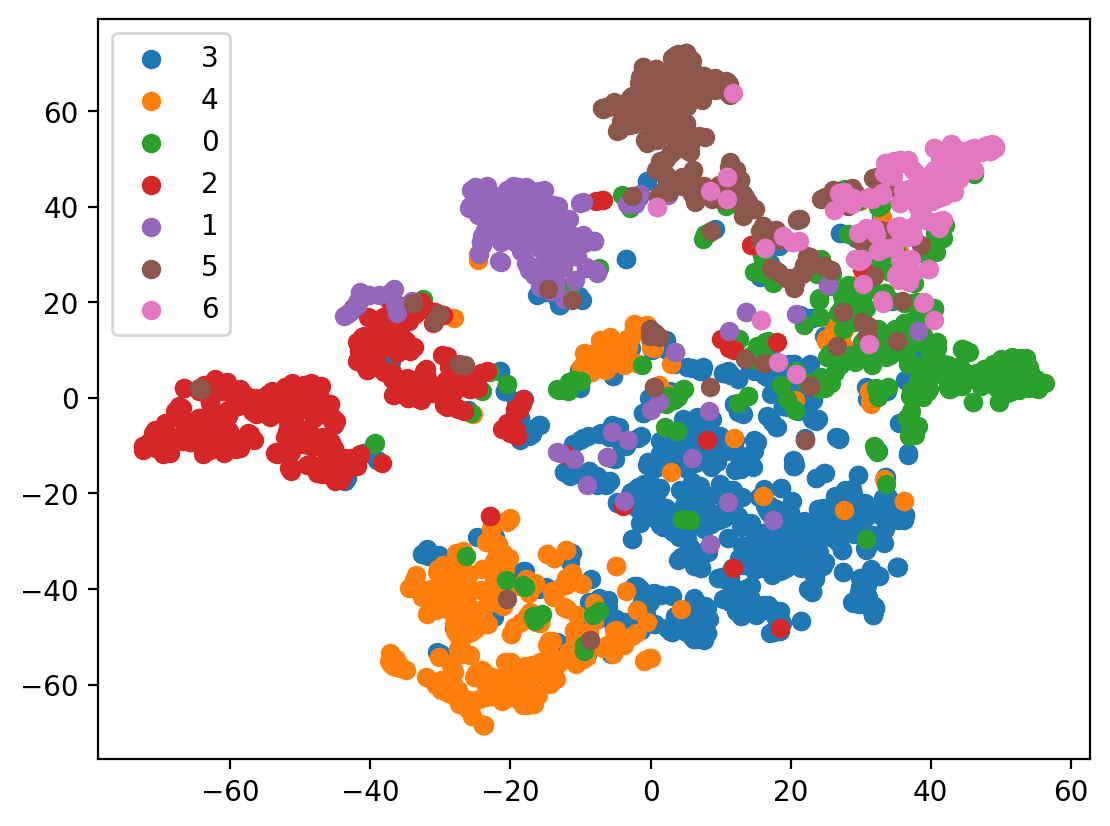

In [5]:
def plot_embeddings(embeddings, X, Y):

    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)

    model = TSNE(n_components=2) ### 降维
    node_pos = model.fit_transform(emb_list)

    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i], [])
        color_idx[Y[i]].append(i)
    plt.figure(dpi=200)
    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)
    plt.legend()
    plt.show()
embedding_weights = model(features).detach().numpy()  ## 得到所有节点的embedding。

plot_embeddings(embedding_weights, np.arange(features.size()[0]), labels.numpy())